In [20]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub as kh
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [2]:
path = kh.dataset_download("afridirahman/brain-stroke-ct-image-dataset")

print("Path to dataset files:", path)


Using Colab cache for faster access to the 'brain-stroke-ct-image-dataset' dataset.
Path to dataset files: /kaggle/input/brain-stroke-ct-image-dataset


In [3]:
base_path =os.path.join(path, 'Brain_Data_Organised')
print(os.listdir(base_path))

['Stroke', 'Normal']


In [4]:
data_dir = base_path

In [5]:
img_size = (224, 224)    # ResNet50 expected input
batch_size = 16          # reduce if you have limited GPU memory
seed = 42
epochs = 10

In [6]:
# 2) Data generators (train / val / test split)
# We will use ImageDataGenerator with validation_split for a quick split.

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rescale=None,
    rotation_range=10,
    validation_split=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [7]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed = seed,
    color_mode='rgb'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed = seed,
    color_mode='rgb'
)

# we'll use the validation set as 'val' and later show evaluation on it.

Found 2001 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [8]:
print("Class indices:", train_generator.class_indices)

Class indices: {'Normal': 0, 'Stroke': 1}


In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("brain_stroke_resnet.keras", save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 56s 363ms/step - accuracy: 0.5748 - loss: 0.8853 - val_accuracy: 0.6160 - val_loss: 0.6634
Epoch 2/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.6344 - loss: 0.6577 - val_accuracy: 0.6200 - val_loss: 0.6534
Epoch 3/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.6388 - loss: 0.6359 - val_accuracy: 0.6160 - val_loss: 0.6443
Epoch 4/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 36s 287ms/step - accuracy: 0.6474 - loss: 0.6171 - val_accuracy: 0.6200 - val_loss: 0.6440
Epoch 5/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6503 - loss: 0.6109 - val_accuracy: 0.6000 - val_loss: 0.6510
Epoch 6/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 278ms/step - accuracy: 0.6686 - loss: 0.5803 - val_accuracy: 0.6320 - val_loss: 0.6491
Epoch 7/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 35s 281ms/step - accuracy: 0.6737 - loss: 0.5955 - val_accuracy: 0.6220 - val_loss: 0.6638
Epoch 8/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 310ms/step - accuracy: 0.6679 - loss: 0

In [19]:
# Evaluation on validation set (acts as test if you didn't set aside test)
val_steps = val_generator.samples // batch_size + 1
val_generator.reset()
pred_probs = model.predict(val_generator, steps=val_steps, verbose=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step


In [21]:
y_true = val_generator.classes[:len(pred_probs)]
y_scores = pred_probs.ravel()[:len(y_true)]
y_pred = (y_scores >= 0.5).astype(int)

In [22]:
print("\nClassification report (validation):")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))


Classification report (validation):
              precision    recall  f1-score   support

      Normal       0.61      0.85      0.71       310
      Stroke       0.34      0.13      0.19       190

    accuracy                           0.57       500
   macro avg       0.48      0.49      0.45       500
weighted avg       0.51      0.57      0.51       500



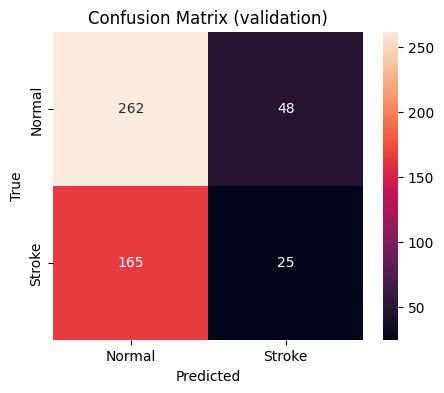

In [23]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (validation)')
plt.show()

In [24]:
# (Optional) Fine-tuning: unfreeze part of base_model and train with low lr
def fine_tune(model, base_model, unfreeze_from_layer_name='conv4_block1_0_conv', lr=1e-5, epochs=5):
    # Unfreeze layers from a named layer (or by index). Here we show unfreezing last conv block.
    set_trainable = False
    for layer in base_model.layers:
        if layer.name == unfreeze_from_layer_name:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print("Trainable layers after unfreezing:")
    for i,layer in enumerate(base_model.layers[-20:], start=1):
        print(i, layer.name, layer.trainable)
    history_ft = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )
    return history_ft


In [25]:
history_ft = fine_tune(model, base_model, unfreeze_from_layer_name='conv4_block1_0_conv', lr=1e-5, epochs=5)

Trainable layers after unfreezing:
1 conv5_block2_1_conv True
2 conv5_block2_1_bn True
3 conv5_block2_1_relu True
4 conv5_block2_2_conv True
5 conv5_block2_2_bn True
6 conv5_block2_2_relu True
7 conv5_block2_3_conv True
8 conv5_block2_3_bn True
9 conv5_block2_add True
10 conv5_block2_out True
11 conv5_block3_1_conv True
12 conv5_block3_1_bn True
13 conv5_block3_1_relu True
14 conv5_block3_2_conv True
15 conv5_block3_2_bn True
16 conv5_block3_2_relu True
17 conv5_block3_3_conv True
18 conv5_block3_3_bn True
19 conv5_block3_add True
20 conv5_block3_out True
Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 99s 525ms/step - accuracy: 0.6939 - loss: 0.5775 - val_accuracy: 0.6500 - val_loss: 0.7255
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - accuracy: 0.7503 - loss: 0.4952 - val_accuracy: 0.6540 - val_loss: 0.7387
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - accuracy: 0.7826 - loss: 0.4457 - val_accuracy: 0.6760 - val_loss: 0.7688
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 300ms

In [46]:
val_steps = val_generator.samples // batch_size + 1
val_generator.reset()
pred_probs = model.predict(val_generator, steps=val_steps, verbose=1)
# flow_from_directory yields batches; we used binary class_mode so labels are in val_generator.classes
y_true = val_generator.classes[:len(pred_probs)]
y_scores = pred_probs.ravel()[:len(y_true)]
y_pred = (y_scores >= 0.5).astype(int)

print("\nClassification report (validation):")
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 345ms/step

Classification report (validation):
              precision    recall  f1-score   support

      Normal       0.63      0.92      0.75       310
      Stroke       0.47      0.11      0.18       190

    accuracy                           0.61       500
   macro avg       0.55      0.52      0.46       500
weighted avg       0.57      0.61      0.53       500



In [40]:
normal = os.path.join(data_dir, 'Normal')
stroke = os.path.join(data_dir, 'Stroke')

In [44]:
from tensorflow.keras.preprocessing import image
def predict_ct(img_path, model, img_size=img_size, threshold=0.5):
    img = image.load_img(img_path, target_size=img_size, color_mode='rgb')
    arr = image.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = preprocess_input(arr)
    prob = float(model.predict(arr)[0][0])
    label = 'Stroke' if prob >= threshold else 'Normal'
    return {"label": label, "probability": prob}

In [43]:
# Example:
print(predict_ct(os.path.join(normal, os.listdir(normal)[0]), model))
print(predict_ct(os.path.join(stroke, os.listdir(stroke)[0]), model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
{'label': 'Normal', 'probability': 0.07503720372915268}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
{'label': 'Stroke', 'probability': 0.5466054081916809}
